In [149]:
import cv2 as cv
import numpy as np
import heapq
import os
from matplotlib import pyplot as plt
from typing import List, Dict, Tuple
from math import log2

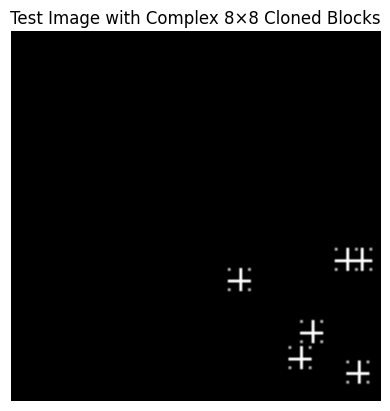

In [ ]:
# def generate_test_image_with_clones(
#     img_shape=(128, 128),
#     block_size=(8, 8),
#     ref_xy=(100, 100),
#     window_size=30,
#     num_clones=5
# ):
#     img = np.zeros(img_shape, dtype=np.float32)

#     # Create a more complex 8x8 white pattern (center cross + corners)
#     block = np.zeros(block_size, dtype=np.float32)
#     center_x, center_y = block_size[0] // 2, block_size[1] // 2
#     block[:, center_y] = 1.0  # vertical bar
#     block[center_x, :] = 1.0  # horizontal bar
#     block[0, 0] = block[0, -1] = block[-1, 0] = block[-1, -1] = 0.7  # bright corners

#     # Insert reference block
#     x0, y0 = ref_xy
#     img[x0:x0+block_size[0], y0:y0+block_size[1]] = block

#     # Clone block into random positions within window around (x0, y0)
#     rng = np.random.default_rng(42)
#     inserted = 0
#     attempts = 0

#     while inserted < num_clones and attempts < 100:
#         dx = rng.integers(-window_size, window_size + 1)
#         dy = rng.integers(-window_size, window_size + 1)
#         x_new, y_new = x0 + dx, y0 + dy

#         # Ensure valid and not same as reference
#         if (x_new == x0 and y_new == y0) or \
#            x_new < 0 or y_new < 0 or \
#            x_new + block_size[0] > img_shape[0] or \
#            y_new + block_size[1] > img_shape[1]:
#             attempts += 1
#             continue

#         img[x_new:x_new+block_size[0], y_new:y_new+block_size[1]] = block
#         inserted += 1

#     return img

# # --- Create and visualize ---
# test_img = generate_test_image_with_clones()
# plt.imshow(test_img, cmap='gray')
# plt.title("Test Image with Complex 8×8 Cloned Blocks")
# plt.axis('off')
# plt.show()


In [484]:
def closest_power_of_2(n: int) -> int:
    r = 1
    while r * 2 <= n:
        r *= 2
    return r

def ind_initialize(max_size: int, N: int, step: int) -> List[int]:
    ind_set = []
    ind = N
    while ind < max_size - N:
        ind_set.append(ind)
        ind += step
    if ind_set and ind_set[-1] < max_size - N - 1:
        ind_set.append(max_size - N - 1)
    return ind_set

def precompute_BM(img: np.ndarray,
                  #width: int,
                  #height: int,
                  kHW: int,
                  NHW: int,
                  nHW: int,
                  pHW: int,
                  tauMatch: float) -> List[List[int]]:
    # Ensure img is flattened and correct size
    height, width = img.shape
    img2d = img
    img = img.astype(np.float32).flatten() / 255.0 

    assert len(img) == width * height, f"Image size mismatch: got {len(img)}, expected {width * height}"
    
    # Declarations
    Ns = 2 * nHW + 1
    threshold = tauMatch * kHW * kHW
    diff_table = np.zeros(width * height, dtype=np.float32)
    sum_table = np.full(((nHW + 1) * Ns, width * height), 2 * threshold, dtype=np.float32)
    patch_table = [[] for _ in range(width * height)]
    
    # Initialize indices
    row_ind = ind_initialize(height - kHW + 1, nHW, pHW)
    column_ind = ind_initialize(width - kHW + 1, nHW, pHW)
    
    # Debug counters
    total_positions = width * height
    positions_with_matches = 0
    positions_processed = 0
    
    print(f"\nInitialization:")
    print(f"Image size: {height}x{width}")
    print(f"Number of row indices: {len(row_ind)}")
    print(f"Number of column indices: {len(column_ind)}")
    print(f"Total positions to process: {len(row_ind) * len(column_ind)}")

    # For each possible distance, precompute inter-patches distance
    for di in range(nHW + 1):
        for dj in range(Ns):
            dk = int(di * width + dj) - int(nHW)
            ddk = di * Ns + dj

            # Process the image containing the square distance between pixels
            for i in range(nHW, height - nHW):
                k = i * width + nHW
                for j in range(nHW, width - nHW):
                    #if 0 <= k + dk < width * height and 0 <= k < width * height:
                    diff_table[k] = (float(img[k + dk]) - float(img[k])) ** 2
                    k += 1

            # Compute the sum for each patches, using integral images
            dn = nHW * width + nHW
            
            # 1st patch, top left corner
            value = 0.0
            for p in range(kHW):
                pq = p * width + dn
                for q in range(kHW):
                    #if pq < width * height:
                    value += diff_table[pq]
                    pq += 1
            sum_table[ddk, dn] = value

            # 1st row, top
            for j in range(nHW + 1, width - nHW):
                ind = nHW * width + j - 1
                sum_val = sum_table[ddk, ind]
                for p in range(kHW):
                    #if ind + p * width + kHW < width * height and ind + p * width < width * height:
                    sum_val += diff_table[ind + p * width + kHW] - diff_table[ind + p * width]
                sum_table[ddk, ind + 1] = sum_val

            # General case
            for i in range(nHW + 1, height - nHW):
                ind = (i - 1) * width + nHW
                sum_val = sum_table[ddk, ind]
                
                # 1st column, left
                for q in range(kHW):
                    #if ind + kHW * width + q < width * height and ind + q < width * height:
                    sum_val += diff_table[ind + kHW * width + q] - diff_table[ind + q]
                sum_table[ddk, ind + width] = sum_val

                # Other columns
                k = i * width + nHW + 1
                pq = (i + kHW - 1) * width + kHW - 1 + nHW + 1
                for j in range(nHW + 1, width - nHW):
                    #if (k < width * height and k - 1 < width * height and 
                        #k - width < width * height and k - 1 - width < width * height and
                        #pq < width * height and pq - kHW < width * height and
                        #pq - kHW * width < width * height and 
                        #pq - kHW - kHW * width < width * height):
                        
                    sum_table[ddk, k] = (sum_table[ddk, k - 1] +
                                        sum_table[ddk, k - width] -
                                        sum_table[ddk, k - 1 - width] +
                                        diff_table[pq] -
                                        diff_table[pq - kHW] -
                                        diff_table[pq - kHW * width] +
                                        diff_table[pq - kHW - kHW * width])
                    k += 1
                    pq += 1

    # Precompute Block Matching
    for ind_i in range(len(row_ind)):
        for ind_j in range(len(column_ind)):
            # Initialization
            k_r = row_ind[ind_i] * width + column_ind[ind_j]
            table_distance = []
            patch_table[k_r] = []
            positions_processed += 1

            # Threshold distances to keep similar patches
            for dj in range(-nHW, nHW + 1):
                # Positive di
                for di in range(nHW + 1):
                    if sum_table[dj + nHW + di * Ns, k_r] < threshold:
                        k_di = k_r + di * width + dj
                        #if 0 <= k_di < width * height:
                        table_distance.append(
                            (float(sum_table[dj + nHW + di * Ns, k_r]), k_di))

                # Negative di
                for di in range(-nHW, 0):
                    if sum_table[-dj + nHW + (-di) * Ns, k_r] < threshold:
                        k_di = k_r + di * width + dj
                        #if 0 <= k_di < width * height:
                        table_distance.append(
                            (float(sum_table[-dj + nHW + (-di) * Ns, k_di]), k_di))

            # Always include self-patch if no matches found
            if len(table_distance) == 0:
                print(f"No matches found for position {k_r} ({k_r//width}, {k_r%width})")
                table_distance.append((0.0, k_r))

            # We need a power of 2 for the number of similar patches,
            # because of the Welsh-Hadamard transform on the third dimension.
            # We assume that NHW is already a power of 2
            nSx_r = closest_power_of_2(len(table_distance)) if NHW > len(table_distance) else NHW

            # To avoid problem
            if nSx_r == 1 and len(table_distance) == 0:
                print("problem size")
                table_distance.append((0.0, k_r))

            # Sort patches according to their distance to the reference one
            table_distance.sort(key=lambda x: x[0])  # Sort by distance (first element of tuple)

            # Keep a maximum of NHW similar patches
            patch_table[k_r] = [pos for _, pos in table_distance[:nSx_r]]

            # To avoid problem
            if nSx_r == 1:
                patch_table[k_r].append(table_distance[0][1])

    # Print debug information
    print(f"\nMatching Statistics:")
    print(f"Total positions in image: {total_positions}")
    print(f"Positions processed: {positions_processed}")
    print(f"Positions with matches: {positions_with_matches}")
    print(f"Empty positions: {sum(1 for matches in patch_table if not matches)}")

    patches = [(i, matches) for i, matches in enumerate(patch_table) if matches]
    stacked = []
    for i, matches in enumerate(patches):
        ref_x = matches[0] // width
        ref_y = matches[0] % width
        #print(f"Reference patch at position ({ref_x}, {ref_y})")
        for match in matches[1]:
            match_x = match // width
            match_y = match % width
            a = img2d[match_x:match_x+2*kHW, match_y:match_y+2*kHW]
            if a.shape == (2*kHW, 2*kHW):
                stacked.append(a)
            #print(f"Match found at position ({match_x}, {match_y})")
    patches3d = np.stack(stacked, axis=0)
    patches2d = patches3d.reshape(len(patches3d), 4 * kHW ** 2)

    return patches3d, patches2d

输入：  
    img：一张2D图像（函数内部会降维到1D进行处理；  
    kHW：理想参考块尺寸的一半  
    NHW：每个参考块的最多匹配数  
    nHW：理想窗口尺寸的一半  
    pHW：遍历参考块时的步长（值越小参考块分布密度越大，反之）  
    tauMatch：约化后的距离阈值（如果距离太大的块直接扔掉）  

输出：  
    patches3d：（总匹配数， 块宽，块高）3D数组，方便直出plot。  
    patches2d：（总匹配数， （块宽 * 块高））2D数组，将每个2D块序列化，矩阵形式方便后续处理。  

该版本的优势：  
    一次性可以在一张图像中遍历多个参考块，并对每个参考块进行一次BM操作，最后获取的patch数量可观；比如对于这个文档里的示例输入图像与超参数设置，跑一遍可以获取665个匹配块。  

该版本的劣势，及与project需求的算法有出入的地方：  
    1）Python版本跑一遍耗时仍然很久，尽管积分图的本意应当是加速机制；  
    2）算法还没有控制non-locality的能力：目前无法严格控制匹配块与参考块的重叠程度，亦无法防止匹配块与匹配快之间的邻近程度。比方如果一个参考块左上角坐标为（15*15），有概率返回（15，16）（15，17）等十分临近的匹配块；  
    3）无法自选每个参考块的绝对坐标，尽管能够调节遍历参考块时的分布步长和密度。  

In [496]:
# Load image
PATH_IMAGE = 'img1_groundtruth_img.png'
img = cv.imread(PATH_IMAGE, cv.IMREAD_GRAYSCALE)
#img = test_img

# Hyper parameters
kHW = 4        # Half width of patches
NHW = 16       # Maximum number of similar patches
nHW = 15        # Half width of search window
pHW = 150       # Step between processed patches
tauMatch = 1 # Distance threshold

# Run block matching
patches3d, patches2d = precompute_BM(img, kHW, NHW, nHW, pHW, tauMatch)


Initialization:
Image size: 700x924
Number of row indices: 6
Number of column indices: 7
Total positions to process: 42

Matching Statistics:
Total positions in image: 646800
Positions processed: 42
Positions with matches: 0
Empty positions: 646758


In [498]:
print(patches2d.shape)
print(patches3d.shape)

(665, 64)
(665, 8, 8)


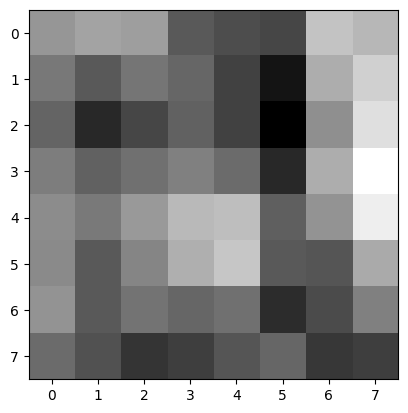

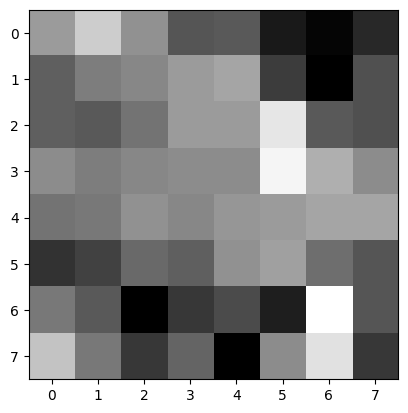

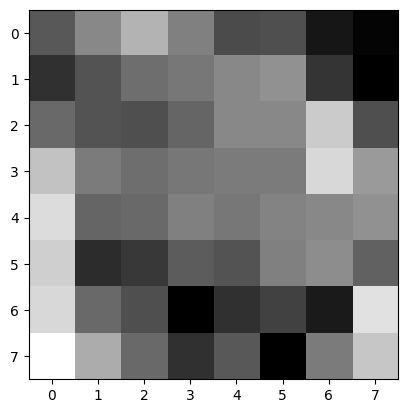

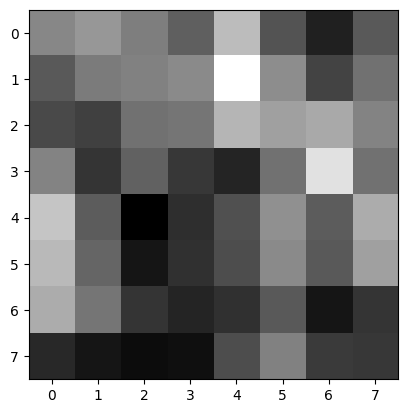

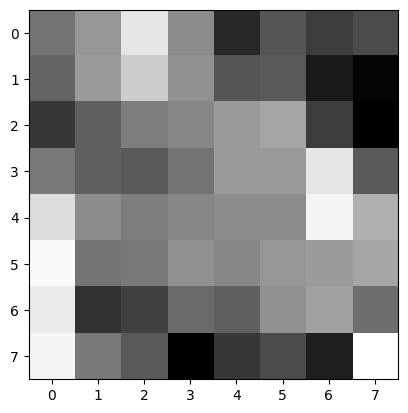

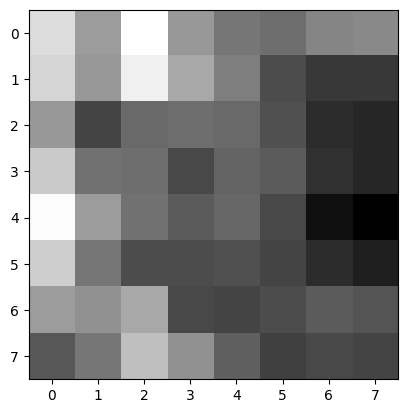

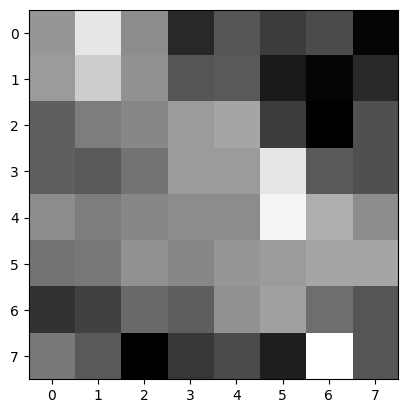

In [500]:
for i, patch in enumerate(patches3d):
    plt.imshow(patch, cmap='gray')
    plt.show()
    if i > 5:
        break
